In [1]:
import os
import numpy as np
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset
import torch
import random
import math
from sklearn.model_selection import StratifiedKFold, KFold
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from numpy import interp
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

In [5]:
# Static data
outputs_root = r'C:\Users\92860\desktop\outputs'

In [72]:
arm_flapping_locations = []
headbanging_locations = []
empty_row = np.zeros(69)
# get root list
v_list = os.listdir(outputs_root)
# loop each video folder
for v_name in tqdm(v_list):
    # get frame rate
    frame_rate = float(v_name.split('_')[-1])
    # generate video path
    v_path = os.path.join(outputs_root, v_name)
    # get clips list under video root
    c_list = os.listdir(v_path)
    # loop each clips
    for c_name in c_list:
        # get behavior, start frame and end frame
        behavior = int(c_name.split('_')[0])
        start_frame = int(c_name.split('_')[1])
        end_frame = int(c_name.split('_')[2])
        #generate clip path
        c_path = os.path.join(v_path, c_name)
        behavior_location_list = []
        # loop the folder by the given frame range
        for idx in range(start_frame, end_frame):
            txt_name = str(idx) + '.txt'
            txt_path = os.path.join(c_path, txt_name)
            # handle the missing frame coordinates file. (in most case is the last frame of the clip)
            if not os.path.exists(txt_path):
                print('missing frame file', idx, c_name, v_name)
                continue
            # read the coordinates for the current frame
            with open(txt_path) as f:
                txt_list = f.readlines()
            
            # read and format the coordinates (x,y,z)
            x_location = txt_list[0].rstrip(' \n').split(' ')
            # handle the undetected frame (insert the zeros)
            if len(x_location) <= 1:
                behavior_location_list.append(empty_row)
                continue
            x_location = [float(x) for x in x_location]
            y_location = txt_list[1].rstrip(' \n').split(' ')
            y_location = [float(y) for y in y_location]
            z_location = txt_list[2].rstrip(' \n').split(' ')
            z_location = [float(z) for z in z_location]
            # we only take the coordinates above the shoulders
            locations = np.concatenate([x_location[0:23], y_location[0:23], z_location[0:23]])
            # length: 69
            behavior_location_list.append(locations)

        #frame rate sync (30-15) (24-12) (15-15) (10-10)
        temp_list = []
        if frame_rate > 18:  # if frame rate is under 18, pass.
            # print('before',len(behavior_location_list))
            index = 0
            # loop the coordinates list by step: 2. if the first has value, then utilize this one as the coordinate of this frame,
            # otherwise the second. If both of them are empty, insert zeros.
            while index < len(behavior_location_list) // 2:
                location_a = behavior_location_list[2 * index]
                location_b = behavior_location_list[2 * index + 1]
                if not np.array_equal(location_a, np.zeros(69)):
                    temp_list.append(location_a)
                elif not np.array_equal(location_b, np.zeros(69)):
                    temp_list.append(location_b)
                else:
                    temp_list.append(empty_row)
                index += 1
            if len(behavior_location_list) % 2 == 1:
                temp_list.append(behavior_location_list[-1])
            # print('after',len(temp_list))

        #handle zero coordinate value
        temp_list2 = []
        # if the length is less than 10, it will be filtered afterward, so pass.
        if len(temp_list) > 10:
            #first loop to handle the single zero value. insert the mean of the neighboring coordinates
            for index in range(1, len(temp_list) - 1):
                if np.array_equal(temp_list[index], np.zeros(69)):
                    if (not np.array_equal(temp_list[index - 1], np.zeros(69))) and (
                    not np.array_equal(temp_list[index + 1], np.zeros(69))):
                        # print(temp_list[index])
                        temp_list[index] = 0.5 * (temp_list[index - 1] + temp_list[index + 1])
                        # print(temp_list[index])
            
            #second loop to handle the consecutive zero value, just divide the clip apart by the zero values.
            p0 = 0
            p1 = 0
            while p1 < len(temp_list):
                if np.array_equal(temp_list[p1], np.zeros(69)):
                    if p1 > p0:
                        temp_list2.append(temp_list[p0:p1]) 
                    p1 += 1
                    p0 = p1
                else:
                    p1 += 1
            if p1 > p0:
                temp_list2.append(temp_list[p0:p1])
                p0 = p1
        # print(len(temp_list))
        # print([len(temp_list2[index]) for index,data in enumerate(temp_list2)])
        
        # according to the behavior category, add it to the corresponding list
        if behavior:
            headbanging_locations.extend(temp_list2)
        else:
            arm_flapping_locations.extend(temp_list2)

100%|██████████| 49/49 [01:42<00:00,  2.09s/it]


In [73]:
# avoid repeated read data
headbanging_locations_copy = headbanging_locations.copy()
arm_flapping_locations_copy = arm_flapping_locations.copy()

In [85]:
# avoid repeated read data
headbanging_locations = headbanging_locations_copy.copy()
arm_flapping_locations = arm_flapping_locations_copy.copy()

In [86]:
# view the length of each clip in both location list
print([len(video) for video in arm_flapping_locations])
print([len(video) for video in headbanging_locations])
# view the length of list
len(arm_flapping_locations), len(headbanging_locations)

[91, 50, 51, 60, 48, 64, 50, 50, 54, 30, 75, 18, 93, 53, 57, 110, 105, 35, 14, 26, 44, 49, 15, 48, 31, 30, 40, 37, 25, 48, 28, 1, 42, 12, 20, 33, 37, 40, 62, 33, 27, 43, 18, 21, 25, 22, 68, 50, 42, 47, 49, 26, 26, 43, 26, 34, 45, 56, 16, 43, 18, 12, 16, 65, 15, 34, 43, 116, 38, 39, 35, 44, 23, 71, 13, 51, 197, 159, 19, 346, 209, 16, 79, 25, 52, 29, 19, 21, 80, 148, 60, 18, 65, 28, 204, 14, 21, 59, 26, 33, 19, 11, 15, 55, 46, 43, 64, 50, 51, 37, 45, 47, 75, 48, 46, 70, 50, 36, 39, 14, 48, 35, 33, 20, 56, 21, 21, 48, 69, 42, 51, 37, 26, 40, 71, 16, 61, 52, 30, 55, 12, 12, 29, 29, 200, 30, 13, 30, 13, 15, 28, 12, 41, 15, 13, 14, 25, 4, 32, 41]
[47, 22, 17, 67, 52, 12, 10, 23, 9, 114, 49, 28, 6, 38, 12, 62, 21, 20, 30, 28, 49, 29, 30, 32, 55, 49, 16, 35, 90, 129, 1, 8, 284, 80, 16, 20, 67, 28, 171, 20, 28, 6, 12, 9, 28, 9, 10, 11, 130, 7, 16, 28, 45, 18, 1, 21, 12, 45, 36, 55, 75, 25, 16, 14, 45, 58, 56, 27, 1, 10, 11, 25, 20, 93, 33, 108, 18, 77, 100, 144, 53, 4, 123]


(160, 83)

In [87]:
# cut the clip into 45 frames each. if the cut is less than 15 frames, abandon it.
def gene_new_locations(locations):
    r_locations = []
    for video in locations:
        length = len(video)
        cnt = 0
        while cnt * 45 < length - 1:
            location = video[cnt * 45:min((cnt + 1) * 45, length)]
            
            # for each cut, we give it a random convert, including flipping, zoom in or out, bias.
            is_x_flip = random.choice([True, False])
            is_y_flip = random.choice([True, False])
            is_z_flip = random.choice([True, False])
            is_zoom_in_or_out = random.choice([True, False])
            bias_x = random.uniform(-0.2, 0.2)
            bias_y = random.uniform(-0.2, 0.2)
            zoom_value = random.uniform(0.9, 1.1)
            for idx, coors in enumerate(location):
                if is_x_flip:
                    coors[0:23] = 1 - coors[0:23]
                if is_y_flip:
                    coors[23:46] = 1 - coors[23:46]
                if is_z_flip:
                    coors[46:69] = - coors[46:69]
                if is_zoom_in_or_out:
                    coors[0:23] = 0.5 * (1 - zoom_value) + coors[0:23] * zoom_value
                    coors[23:46] = 0.5 * (1 - zoom_value) + coors[23:46] * zoom_value
                    coors[46:69] = zoom_value * coors[46:69]
                coors[0:23] += bias_x
                coors[23:46] += bias_y
                location[idx] = coors
            r_locations.append(location)
            cnt += 1
    remove_list = []
    for idx, data in enumerate(r_locations):
        if len(data) < 15:
            remove_list.append(idx)
    for idx in remove_list[::-1]:
        r_locations.__delitem__(idx)
    return r_locations


arm_flapping_locations = gene_new_locations(arm_flapping_locations)
headbanging_locations = gene_new_locations(headbanging_locations)

In [88]:
# view the length after cutting
print([len(video) for video in arm_flapping_locations])
print()
print([len(video) for video in headbanging_locations])
len(arm_flapping_locations), len(headbanging_locations)

[45, 45, 45, 45, 45, 15, 45, 45, 19, 45, 45, 45, 30, 45, 30, 18, 45, 45, 45, 45, 45, 45, 20, 45, 45, 15, 35, 26, 44, 45, 15, 45, 31, 30, 40, 37, 25, 45, 28, 42, 20, 33, 37, 40, 45, 17, 33, 27, 43, 18, 21, 25, 22, 45, 23, 45, 42, 45, 45, 26, 26, 43, 26, 34, 45, 45, 16, 43, 18, 16, 45, 20, 15, 34, 43, 45, 45, 26, 38, 39, 35, 44, 23, 45, 26, 45, 45, 45, 45, 45, 17, 45, 45, 45, 24, 19, 45, 45, 45, 45, 45, 45, 45, 31, 45, 45, 45, 45, 29, 16, 45, 34, 25, 45, 29, 19, 21, 45, 35, 45, 45, 45, 45, 15, 18, 45, 20, 28, 45, 45, 45, 45, 24, 21, 45, 26, 33, 19, 15, 45, 45, 43, 45, 19, 45, 45, 37, 45, 45, 45, 30, 45, 45, 45, 25, 45, 36, 39, 45, 35, 33, 20, 45, 21, 21, 45, 45, 24, 42, 45, 37, 26, 40, 45, 26, 16, 45, 16, 45, 30, 45, 29, 29, 45, 45, 45, 45, 20, 30, 30, 15, 28, 41, 15, 25, 32, 41]

[45, 22, 17, 45, 22, 45, 23, 45, 45, 24, 45, 28, 38, 45, 17, 21, 20, 30, 28, 45, 29, 30, 32, 45, 45, 16, 35, 45, 45, 45, 45, 39, 45, 45, 45, 45, 45, 45, 45, 35, 16, 20, 45, 22, 28, 45, 45, 45, 36, 20, 28, 28, 4

(197, 91)

In [89]:
# Sort the coordinate sequence with more information first
arm_flapping_locations = sorted(arm_flapping_locations, key=lambda x: len(x), reverse=True)
print([len(video) for video in arm_flapping_locations])
len(arm_flapping_locations), len(headbanging_locations)

[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 43, 43, 43, 43, 43, 42, 42, 42, 41, 41, 40, 40, 40, 39, 39, 38, 37, 37, 37, 37, 36, 35, 35, 35, 35, 34, 34, 34, 33, 33, 33, 33, 32, 31, 31, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 29, 28, 28, 28, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 25, 25, 25, 25, 25, 24, 24, 24, 23, 23, 22, 21, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18, 18, 17, 17, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15]


(197, 91)

In [90]:
# balance sample
arm_flapping_locations = arm_flapping_locations[:91]
len(arm_flapping_locations), len(headbanging_locations)

(91, 91)

In [91]:
# create a padding function in order to pad 
def pad(locations, maxlen=45, padding="pre", truncating="post"):
    new_locations = locations
    empty_row = np.zeros((1, 69))
    for i, video in tqdm(enumerate(new_locations)):
        if len(video) < maxlen:
            for new_row in range(maxlen - len(video)):
                if padding == "post":
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre":
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen:
            if truncating == "post":
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre":
                new_locations[i] = new_locations[i][len(video) - maxlen:]
    return np.array(new_locations)


padded_arm_flapping_locations = arm_flapping_locations
padded_headbanging_locations = headbanging_locations
padded_arm_flapping_locations = pad(padded_arm_flapping_locations, maxlen=45)
padded_headbanging_locations = pad(padded_headbanging_locations, maxlen=45)
padded_arm_flapping_locations.shape, padded_headbanging_locations.shape

91it [00:00, ?it/s]
91it [00:00, 22739.45it/s]


((91, 45, 69), (91, 45, 69))

In [92]:
# generate inputs and labels
def generate_data(arm_flapping_locations, headbanging_locations):
    arm_flapping_labels = np.array([[1, 0]] * len(arm_flapping_locations))
    headbanging_labels = np.array([[0, 1]] * len(headbanging_locations))
    # concatenate 
    data = np.concatenate([arm_flapping_locations, headbanging_locations], axis=0)
    labels = np.concatenate([arm_flapping_labels, headbanging_labels], axis=0)
    return data, labels


x, y = generate_data(padded_arm_flapping_locations, padded_headbanging_locations)
x.shape, y.shape

((182, 45, 69), (182, 2))

In [93]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs):
    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)):
        plt.plot(base_fpr, tpr, label=f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label="average of folds")

    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label="chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color="green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show()

    return mean_tpr, mean_auroc


In [94]:
# define model
class ASDModel(nn.Module):
    def __init__(self):
        super(ASDModel, self).__init__()
        self.lstm = nn.LSTM(69, 128, 1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print(x.shape)
        x, (ht, ct) = self.lstm(x)
        # print(x.shape)
        x = x[:, -1, :]
        # print(x.shape)
        x = self.dropout(x)
        x = self.linear(x)
        # print(x.shape)
        x = self.softmax(x)
        return x

# define dataset
class ASDDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, item):
        return self.inputs[item], self.labels[item]

    def __len__(self):
        return len(self.inputs)

## About the normalization and standardization 
Since the MideaPipe detection model has limit the coordinates value within [-1,1], so we do not have to repeat the process step.
And for the data leakage. Since we have utilized the data augment methods to convert each coordinates sequence data, so we can get rid of this risk.

device cpu
train loss 0.45828232
test loss 0.60607016
____________________________________________________________
Accuracy_score: 0.7027027027027027
roc_auc_score: 0.7046783625730993
               precision    recall  f1-score   support

Hand Flipping       0.75      0.63      0.69        19
  HeadBanging       0.67      0.78      0.72        18

     accuracy                           0.70        37
    macro avg       0.71      0.70      0.70        37
 weighted avg       0.71      0.70      0.70        37

____________________________________________________________


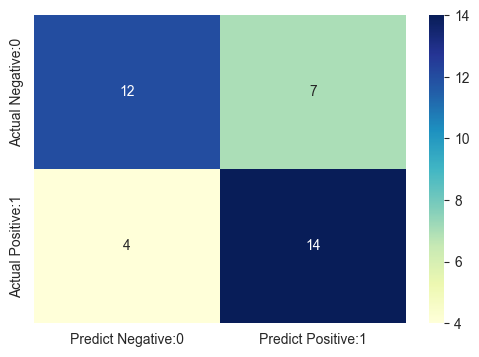

device cpu
train loss 0.450013
test loss 0.6496509
____________________________________________________________
Accuracy_score: 0.6756756756756757
roc_auc_score: 0.6754385964912282
               precision    recall  f1-score   support

Hand Flipping       0.67      0.67      0.67        18
  HeadBanging       0.68      0.68      0.68        19

     accuracy                           0.68        37
    macro avg       0.68      0.68      0.68        37
 weighted avg       0.68      0.68      0.68        37

____________________________________________________________


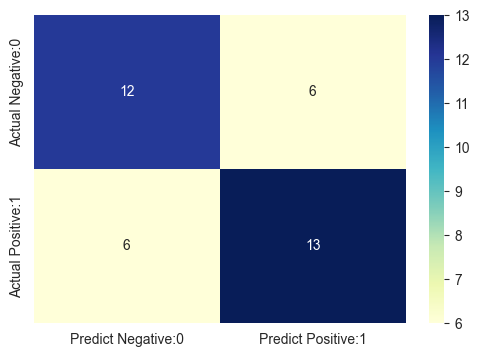

device cpu
train loss 0.4898866
test loss 0.661166
____________________________________________________________
Accuracy_score: 0.6111111111111112
roc_auc_score: 0.6111111111111112
               precision    recall  f1-score   support

Hand Flipping       0.60      0.67      0.63        18
  HeadBanging       0.62      0.56      0.59        18

     accuracy                           0.61        36
    macro avg       0.61      0.61      0.61        36
 weighted avg       0.61      0.61      0.61        36

____________________________________________________________


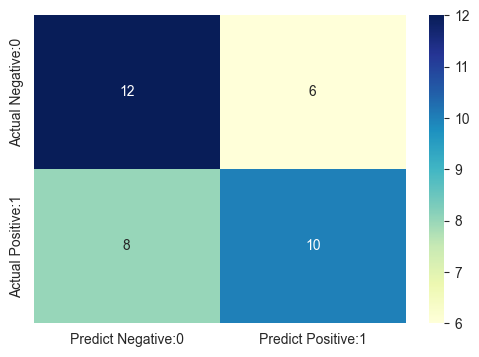

device cpu
train loss 0.47250518
test loss 0.6485611
____________________________________________________________
Accuracy_score: 0.6388888888888888
roc_auc_score: 0.638888888888889
               precision    recall  f1-score   support

Hand Flipping       0.63      0.67      0.65        18
  HeadBanging       0.65      0.61      0.63        18

     accuracy                           0.64        36
    macro avg       0.64      0.64      0.64        36
 weighted avg       0.64      0.64      0.64        36

____________________________________________________________


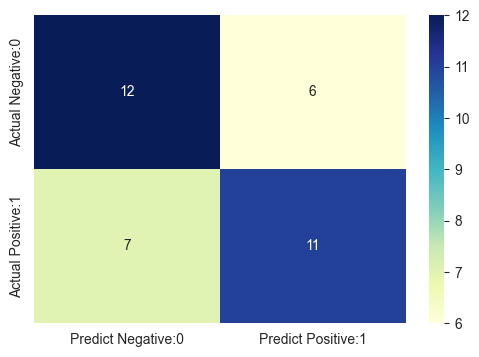

device cpu
train loss 0.4656887
test loss 0.57524824
____________________________________________________________
Accuracy_score: 0.6944444444444444
roc_auc_score: 0.6944444444444445
               precision    recall  f1-score   support

Hand Flipping       0.71      0.67      0.69        18
  HeadBanging       0.68      0.72      0.70        18

     accuracy                           0.69        36
    macro avg       0.70      0.69      0.69        36
 weighted avg       0.70      0.69      0.69        36

____________________________________________________________


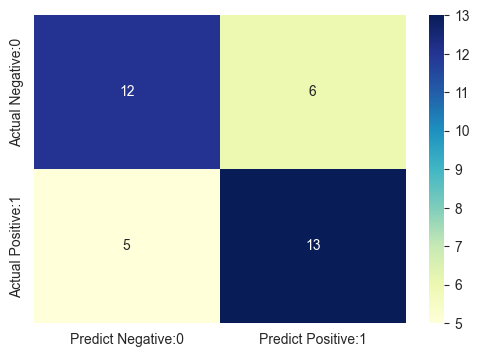

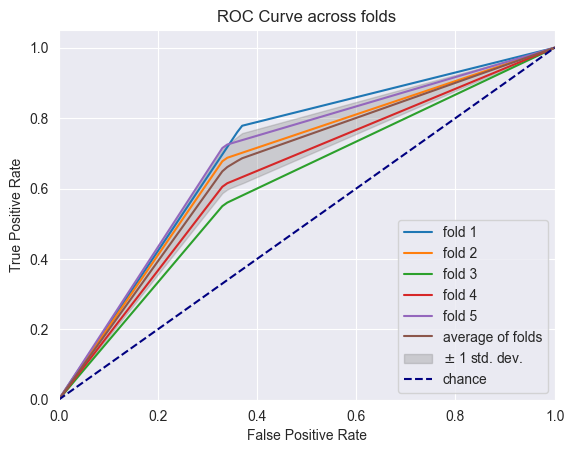

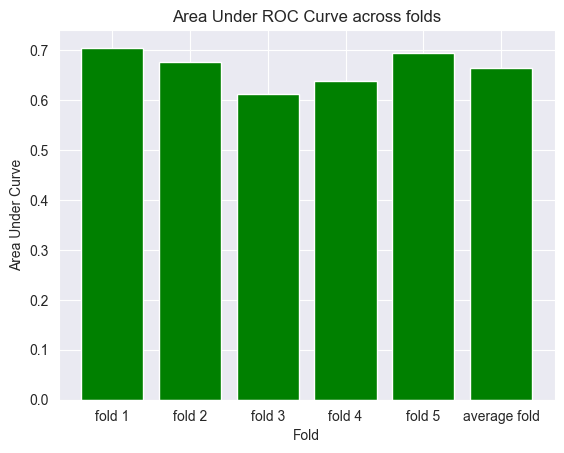

mean_auroc_score: 0.6649122807017545


In [95]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
skf = StratifiedKFold(n_splits=5, shuffle=False)
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
base_fpr = np.linspace(0, 1, 101)
FPRS, TPRS, AUROCS = [], [], []
# split data by stratifiedkfold, k = 5
for idx, (train_index, test_index) in enumerate(skf.split(x, np.argmax(y, axis=1))):
    # get train and test data
    x_train, x_test = np.array(x)[train_index], np.array(x)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
    # initial train data loder
    train_dataset = ASDDataset(x_train, y_train)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=0)
    # initial test data loader
    test_dataset = ASDDataset(x_test, y_test)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=600, shuffle=True, num_workers=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device", device)
    # create model object
    net = ASDModel().to(device)
    # define learning rate
    lr = 0.01
    # define epoch number
    epoch_num = 100
    # define loss function
    loss_func = torch.nn.CrossEntropyLoss().to(device)
    # define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # define scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
    for epoch in range(epoch_num):
        # train
        net.train()
        train_loss_list = []
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            loss.requires_grad_(True)
            train_loss_list.append(loss.cpu().data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
    # we just output the last epoch train loss
    print("train loss", np.mean(np.array(train_loss_list)))
    
    
    # test
    net.eval()
    test_loss_list = []
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        outputs = net(inputs)
        _, y_pred = torch.max(outputs, 1)
        _, _labels = torch.max(labels, 1)
        loss = loss_func(outputs, labels)
        test_loss_list.append(loss.cpu().data)
    
    fpr, tpr, _ = roc_curve(_labels, y_pred)
    FPRS.append(fpr)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    TPRS.append(tpr)
    AUROCS.append(roc_auc_score(_labels, y_pred))
    
    # print results
    print("test loss", np.mean(np.array(test_loss_list)))
    print("_" * 60)
    print(f'Accuracy_score: {accuracy_score(_labels, y_pred)}')
    print(f'roc_auc_score: {roc_auc_score(_labels, y_pred)}')
    print(classification_report(_labels, y_pred, target_names=['Hand Flipping', 'HeadBanging']))
    print("_" * 60)
    
    # print confusion matrix
    cm = confusion_matrix(_labels, y_pred)
    plt.figure(figsize=(6, 4))
    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'],
                             index=['Actual Negative:0', 'Actual Positive:1'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

# print the roc curve for 5 folds
mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS)
print('mean_auroc_score:', mean_auroc)


